# Final Project: CHECKPOINT 1. 
Github link: https://github.com/kashyapkolukula/CMSC320_S25_Project

Datasets: 
* NBA Salaries: Hoops Fortune (2020-2025) https://www.kaggle.com/datasets/omarsobhy14/nba-players-salaries?resource=download
* NBA Stats (1947-present) https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats




# Final Project: CHECKPOINT 2. 
TODO: Submit a Jupyter notebook file (.ipynb) to Gradescope

Directions:
* (5 points) Data preprocessing: (a) import, (b) parse (e.g., convert strings to ints), (c) organize   (e.g., set up a database or a pandas DataFrame).
* (20 points) Basic data exploration and summary statistics
* You must present three conclusions using at least three different statistical methods, including hypothesis testing.
* For example: What are the main characteristics of your dataset? How many features and entries are there? Is a feature over-represented? Are features correlated? Are there outliers? Identify the attributes that will affect your choice of primary analysis technique. Etcetera.
* For each method, you must have at least one gorgeous plot.




In [38]:
'''Kaggle datasts have been downloaded and can be found in "Data" folder.'''
# imports and libraries (not all may be needed)
import pandas as pd
from datetime import datetime
import string
import re
import requests
import sqlite3
conn = sqlite3.connect("database.sqlite")
crsr = conn.cursor()
from collections import Counter

In [39]:
''' DATA PROCESSING '''
# In NBA_Salaries folder
salaries_df = pd.read_csv("Data/NBA_Salaries_Hoops_Fortune_2020-2025/Nba Player Salaries.csv")

# In NBA_Stats folder
df_advanced = pd.read_csv("Data/NBA_Stats_1947-present/Advanced.csv")
df_advanced = df_advanced.drop(columns=['birth_year']) # mostly NA (91%)

df_all_star_selections = pd.read_csv("Data/NBA_Stats_1947-present/All-Star Selections.csv")

df_end_season_teams_voting = pd.read_csv("Data/NBA_Stats_1947-present/End of Season Teams (Voting).csv")

df_end_season_teams = pd.read_csv("Data/NBA_Stats_1947-present/End of Season Teams.csv")
df_end_season_teams = df_end_season_teams.drop(columns=['birth_year']) # mostly NA (86%)

df_opponent_stats_per_100 = pd.read_csv("Data/NBA_Stats_1947-present/Opponent Stats Per 100 Poss.csv")

df_opponent_stats_per_game = pd.read_csv("Data/NBA_Stats_1947-present/Opponent Stats Per Game.csv")

df_opponent_totals = pd.read_csv("Data/NBA_Stats_1947-present/Opponent Totals.csv")

df_per_36 = pd.read_csv("Data/NBA_Stats_1947-present/Per 36 Minutes.csv")
df_per_36 = df_per_36.drop(columns=['birth_year']) # mostly NA (91%)

df_per_100_poss = pd.read_csv("Data/NBA_Stats_1947-present/Per 100 Poss.csv")
df_per_100_poss = df_per_100_poss.drop(columns=['birth_year']) # mostly NA (95%)

df_player_award_shares = pd.read_csv("Data/NBA_Stats_1947-present/Player Award Shares.csv")

df_player_career_info = pd.read_csv("Data/NBA_Stats_1947-present/Player Career Info.csv")
df_player_career_info = df_player_career_info.drop(columns=['birth_year']) # mostly NA (93%)

df_player_directory = pd.read_csv("Data/NBA_Stats_1947-present/Player Directory.csv")

# Unlikely to be used
df_player_per_game = pd.read_csv("Data/NBA_Stats_1947-present/Player Per Game.csv")
df_player_per_game = df_player_per_game.drop(columns=['birth_year']) # mostly NA (91%)

# Unlikely to be used
df_player_play_by_play = pd.read_csv("Data/NBA_Stats_1947-present/Player Play By Play.csv")
df_player_play_by_play = df_player_play_by_play.drop(columns=['birth_year']) # mostly NA (99%)

df_player_season_info = pd.read_csv("Data/NBA_Stats_1947-present/Player Season Info.csv")
df_player_season_info = df_player_season_info.drop(columns=['birth_year']) # mostly NA (91%)

df_player_shooting = pd.read_csv("Data/NBA_Stats_1947-present/Player Shooting.csv")
df_player_shooting = df_player_shooting.drop(columns=['birth_year']) # mostly NA (99%)

df_player_totals = pd.read_csv("Data/NBA_Stats_1947-present/Player Totals.csv")
df_player_totals = df_player_totals.drop(columns=['birth_year']) # mostly NA (91%)

# Unlikely to be used
df_team_abbrev = pd.read_csv("Data/NBA_Stats_1947-present/Team Abbrev.csv")

df_team_stats_per_100 = pd.read_csv("Data/NBA_Stats_1947-present/Team Stats Per 100 Poss.csv")

df_team_stats_per_game = pd.read_csv("Data/NBA_Stats_1947-present/Team Stats Per Game.csv")

df_team_summaries = pd.read_csv("Data/NBA_Stats_1947-present/Team Summaries.csv")

df_team_totals = pd.read_csv("Data/NBA_Stats_1947-present/Team Totals.csv")


In [40]:
salary_long = (
    salaries_df
    .melt(id_vars="Player Name", 
          value_vars=["2022/2023", "2023/2024", "2024/2025"],
          var_name="Season", 
          value_name="Salary")
    .replace({"Salary": r"[\$,]"}, {"Salary": ""}, regex=True)
    .assign(
        Salary=lambda d: pd.to_numeric(d["Salary"], errors="coerce"),
        player=lambda d: d["Player Name"].str.strip(),
        season=lambda d: d["Season"].str.extract(r"(\d{4})").astype(int)
    )
    .drop(columns=["Player Name"])
    .dropna(subset=["Salary"])
)

In [41]:
df_advanced["player"] = df_advanced["player"].str.strip()
df_advanced = df_advanced[df_advanced["lg"] == "NBA"]
df_advanced = df_advanced[df_advanced["season"].between(2020, 2025)]

In [42]:
gold_df = pd.merge(
    df_advanced,
    salary_long,
    on=["player", "season"],
    how="inner"
).reset_index(drop=True)

print(gold_df.shape)

(1618, 33)


Notes from cleaning up the data:
* There are 5266 players total.
* Advanced has the most general data
* Many columns are repeated (kaggle has better visuals)
* Many of the loaded df's can be used to create columns of players with certain characteristics
* Dropped birth year since there is age in the "advanced_df"

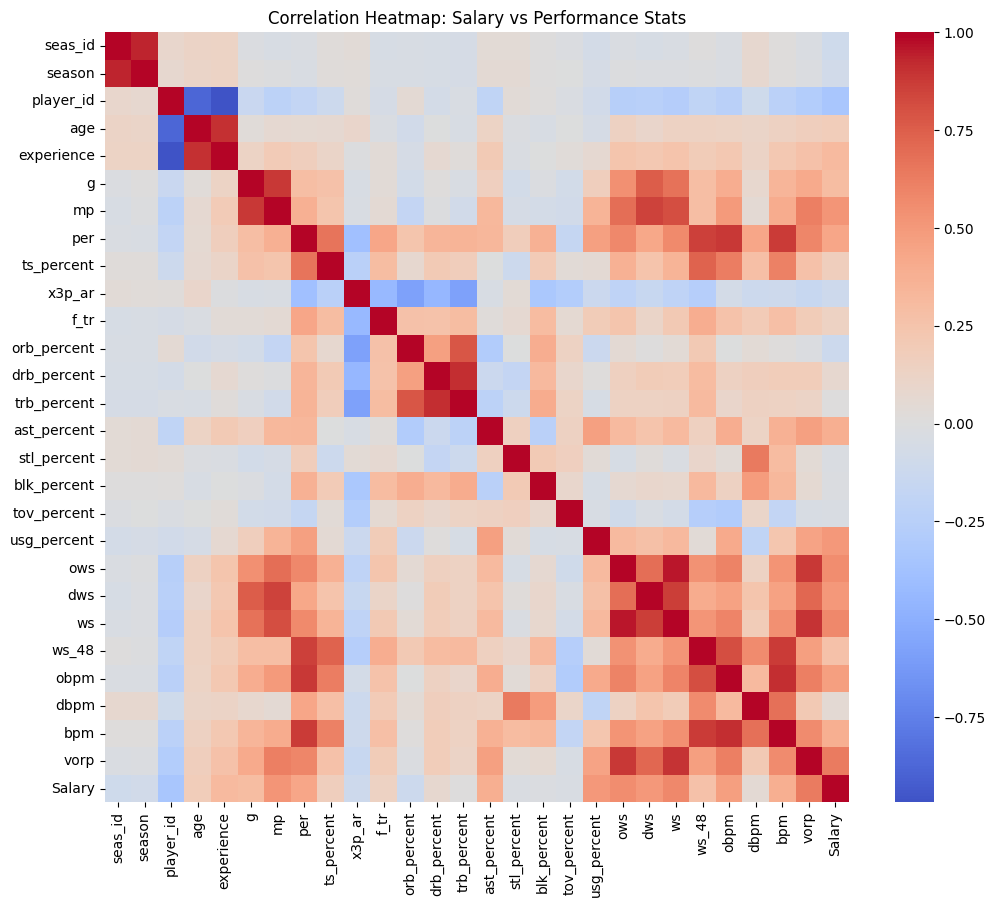

Salary         1.000000
vorp           0.637568
ws             0.581336
ows            0.554892
mp             0.518558
dws            0.507142
usg_percent    0.501092
obpm           0.475854
per            0.432603
bpm            0.389472
Name: Salary, dtype: float64


In [44]:
correlation_matrix = gold_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Salary vs Performance Stats")
plt.show()

print(correlation_matrix["Salary"].sort_values(ascending=False).head(10))

In [45]:
''' DATA EXPLORATION AND SUMMARY STATISTICS'''

' DATA EXPLORATION AND SUMMARY STATISTICS'